In [347]:
"""
!git clone -b EMT https://github.com/pop756/Quantum_KAN.git
%cd Quantum_KAN
!pip install -r requirements.txt"""

'\n!git clone -b EMT https://github.com/pop756/Quantum_KAN.git\n%cd Quantum_KAN\n!pip install -r requirements.txt'

In [348]:
import pennylane as qml
from pennylane import numpy as np
import random





def ising_model_circuit(num_qubits=4,num_layer = 2,single='X',double='ZZ',J=0.25,h=0.125):
    """
    Creates a parameterized quantum circuit for simulating the Ising model
    with specified number of qubits and layers. The circuit includes random 
    interaction strengths and external field strengths.
    
    Args:
    num_qubits (int): Number of qubits in the circuit.
    num_layer (int): Number of layers of Ising interactions and external field terms.
    
    Returns:
    cost (function): The cost function which returns the expected value of the PauliZ observable on the first qubit.
    """
        
    # Define the device
    dev = qml.device("default.mixed", wires=num_qubits)
    
    # Define random interaction strengths and external field strengths
    J = np.array(list([J])*num_qubits)
    h = np.array(list([h])*num_qubits)

    def circuit(params):
        # Apply RX rotations with parameters
        for i in range(num_qubits):
            qml.RX(params[i], wires=i)
        for j in range(num_layer):
            # Apply Ising ZZ interactions
            for i in range(num_qubits - 1):
                getattr(qml,f"Ising{double}")(2 * J[i], wires=[i, i+1])

            
            # Apply external field X terms
            for i in range(num_qubits):
                getattr(qml,f"R{single}")(2 * h[i], wires=i)

    # Define the Ising model Hamiltonian
    coeffs = []
    obs = []

    @qml.qnode(dev,interface='torch')
    def cost(params):
        circuit(params)
        return qml.expval(qml.Identity(0))
    
    return cost


num_qubits=4
# 랜덤 게이트 선택 함수
def random_gate():
    gates = [
        qml.RX,
        qml.RY,
        qml.RZ,
        qml.CNOT,
        qml.CZ
    ]
    return np.random.choice(gates)

# 랜덤 파라미터 생성 함수
def random_parameters(gate):
    if gate in [qml.RX, qml.RY, qml.RZ]:
        return [np.random.uniform(0, 2 * np.pi)]
    return []

# 랜덤 회로 생성 함수
def create_random_circuit(num_gates,params):
    def circuit():
        index=0
        for _ in range(num_gates):
            gate = random_gate()
            if gate in [qml.CNOT, qml.CZ]:
                qubits = np.random.choice(num_qubits, 2, replace=False)
                gate(wires=qubits)
            else:
                qubits = [np.random.choice(num_qubits)]
                gate(params[index], wires=qubits)
                index +=1
    return circuit

# 랜덤 회로 생성
num_gates = 5  # 사용할 게이트 수
random_circuit = create_random_circuit(num_gates)
dev = qml.device("default.mixed", wires=num_qubits)
@qml.qnode(dev)
def quantum_circuit():
    random_circuit()
    return qml.Identity(0)


# Example usage
num_parameters = 4  # One parameter per qubit for RX rotations
params = list(np.random.uniform(0, 2 * np.pi, num_parameters))
random_circuit = ising_model_circuit(4,2,single='Y',double='ZZ',J=0.25,h=0.125)
train_circuit = ising_model_circuit(4,2,single='Y',double='ZZ',J=0.,h=0.125)



print(random_circuit(params))
print(qml.draw(random_circuit)(params))


0.9999999999999993
0: ──RX(3.45)─╭IsingZZ(0.50)──RY(0.25)─────────────────────╭IsingZZ(0.50)──RY(0.25)─────
1: ──RX(4.49)─╰IsingZZ(0.50)─╭IsingZZ(0.50)──RY(0.25)──────╰IsingZZ(0.50)─╭IsingZZ(0.50)
2: ──RX(3.79)────────────────╰IsingZZ(0.50)─╭IsingZZ(0.50)──RY(0.25)──────╰IsingZZ(0.50)
3: ──RX(3.42)───────────────────────────────╰IsingZZ(0.50)──RY(0.25)────────────────────

───────────────────────────┤  <I>
───RY(0.25)────────────────┤     
──╭IsingZZ(0.50)──RY(0.25)─┤     
──╰IsingZZ(0.50)──RY(0.25)─┤     


In [629]:
import pennylane as qml
import numpy as np
import random


# 디바이스 설정
num_qubits = 6  # 사용하고 싶은 큐비트 수
pauli_list = ['X','Y','Z']


meas1 = qml.Hamiltonian([1]*num_qubits, [getattr(qml,f"Pauli{pauli_list[random.randint(0,2)]}")(i) for i in range(num_qubits)],grouping_type='qwc')
dev = qml.device("default.mixed", wires=num_qubits)

# 랜덤 게이트 선택 함수
def random_gate():
    gates = [
        qml.RX,
        qml.RY,
        qml.RZ,
        qml.CRX,
        qml.CRZ
    ]
    return np.random.choice(gates)

# 랜덤 파라미터 생성 함수
def random_parameters(gate):
    if gate in [qml.RX, qml.RY, qml.RZ, qml.CRX, qml.CRZ]:
        return [np.random.uniform(0, 2 * np.pi)]
    return []

# 랜덤 회로 생성 함수
def create_random_circuit(num_gates,seed=21):
    def train_circuit(params):
        np.random.seed(seed)
        num_params = 0
        for _ in range(num_gates):
            gate = random_gate()
            if gate in [qml.CRX, qml.CRZ]:
                qubits = np.array(np.random.choice(range(num_qubits), 2, replace=False))
                gate(0,wires=qubits)
            else:
                qubits = [np.random.choice(num_qubits)]
                gate(params[num_params], wires=qubits)
            num_params+=1
    def test_circuit(params):
        np.random.seed(seed)
        num_params = 0
        for _ in range(num_gates):
            gate = random_gate()
            if gate in [qml.CRX, qml.CRZ]:
                qubits = np.array(np.random.choice(range(num_qubits), 2, replace=False))
            else:
                qubits = [np.random.choice(num_qubits)]
            gate(params[num_params], wires=qubits)
            num_params+=1
    return train_circuit,test_circuit

# 랜덤 회로 생성
num_gates = 20  # 사용할 게이트 수
train,val = create_random_circuit(num_gates,seed=random.randint(0,200))

@qml.qnode(dev)
def test_circuit(params):
    val(params )
    return qml.expval(meas1) 

@qml.qnode(dev)
def train_circuit(params):
    train(params)
    return qml.expval(meas1) 



In [631]:
print(qml.draw(train_circuit)([1]*num_gates))
print(meas1)
print(qml.draw(test_circuit)([1]*num_gates))

0: ──RZ(1.00)──RX(1.00)─────────────────────╭●──────────────────────────────────────╭●───────
1: ─────────────────────────────────────────│───────────────────╭RZ(0.00)──RZ(1.00)─│────────
2: ─╭●─────────RX(1.00)───────────╭●────────│──────────RX(1.00)─│───────────────────│────────
3: ─╰RZ(0.00)─────────────────────│─────────╰RZ(0.00)─╭●────────│───────────────────╰RX(0.00)
4: ─╭RX(0.00)───────────╭RX(0.00)─╰RZ(0.00)──RX(1.00)─╰RX(0.00)─╰●───────────────────────────
5: ─╰●─────────RZ(1.00)─╰●─────────RY(1.00)──RX(1.00)──RX(1.00)──────────────────────────────

───RZ(1.00)─┤ ╭<𝓗>
───RZ(1.00)─┤ ├<𝓗>
────────────┤ ├<𝓗>
────────────┤ ├<𝓗>
────────────┤ ├<𝓗>
────────────┤ ╰<𝓗>
  (1) [Y0]
+ (1) [Y1]
+ (1) [Y2]
+ (1) [Y3]
+ (1) [Y4]
+ (1) [Z5]
0: ──RZ(1.00)──RX(1.00)─────────────────────╭●──────────────────────────────────────╭●───────
1: ─────────────────────────────────────────│───────────────────╭RZ(1.00)──RZ(1.00)─│────────
2: ─╭●─────────RX(1.00)───────────╭●────────│──────────RX(1.00)─│──

In [632]:
import pennylane as qml
from pennylane import numpy as np
import torch

def extra_polation(circ,H,theta,noise_factor=[1,3,5],p1=0.01,p2=0.02):
    """게이트 폴딩으로 노이즈를 만들고 그 결과 출력

    Args:
        circ (qnode): _들어갈 서킷_
        H (qml.Hamiltonian): _측정할 기저_
        theta (list): _서킷에 임의로 넣을 변수값_
        noise_factor (list, optional): _게이트 폴딩 노이즈 팩터(2n+1)_. Defaults to [1,3,5].
        p1 (float, optional): _CNOT dephasing 확률_. Defaults to 0.01.
        p2 (float, optional): _CNOT bitflip 확률_. Defaults to 0.02.

    Returns:
        res(list),real_value(float): 노이즈 팩터 리스트,실제 서킷 값 
    """
    circ(theta)
    dev = circ.device
    ops = circ.qtape.operations
    ops_inv = ops[::-1]
    noise_factor1 = (np.array(noise_factor)+1)/2-1
    noise_factor = np.asarray(noise_factor1,dtype=int)
    
    if (noise_factor != noise_factor1).all():
        print("input is not suitable(2n+1)")
        raise
    
    @qml.qnode(dev)
    def real_circ():
        tensor = torch.tensor
        
        for op in ops:
            eval(f'qml.{op}')
        return qml.expval(H)
    
    def noise_circ():
        tensor = torch.tensor
        for op in ops:
            eval(f'qml.{op}')
            if len(op.wires)>1:
                for wire in op.wires:
                    qml.DepolarizingChannel(p1, wires=wire)
                    qml.BitFlip(p2, wires=wire)
            else:
                qml.DepolarizingChannel(p1, wires=op.wires) 
                qml.BitFlip(p2, wires=op.wires)
    def noise_circ_inv():
        tensor = torch.tensor
        for op in ops_inv:
            eval(f'qml.adjoint(qml.{op})')
            if len(op.wires)>1:
                for wire in op.wires:
                    qml.DepolarizingChannel(p1, wires=wire)
                    qml.BitFlip(p2, wires=wire)
            else:
                qml.DepolarizingChannel(p1, wires=op.wires) 
                qml.BitFlip(p2, wires=op.wires)
    
    @qml.qnode(dev,interface='torch')
    def extra_polation(factor):
        for i in range(factor):
            noise_circ()
            noise_circ_inv()
        noise_circ()
        return qml.expval(H)
    




    res = []
    real_value = real_circ()
    for factor in noise_factor:
        res.append(extra_polation(factor))
    return res,real_value

def extra_polation_time(circ,H,theta,noise_factor=[1,1.5,2],p1=0.01,p2=0.02):
    """노이즈를 키워 서킷을 만들고 그 노이즈 서킷의 결과 출력

    Args:
        circ (qnode): _들어갈 서킷_
        H (qml.Hamiltonian): _측정할 기저_
        theta (list): _서킷에 임의로 넣을 변수값_
        noise_factor (list, optional): _time 노이즈 팩터_. Defaults to [1,1.5,2].
        p1 (float, optional): _CNOT dephasing 확률_. Defaults to 0.01.
        p2 (float, optional): _CNOT bitflip 확률_. Defaults to 0.02.

    Returns:
        res(list),real_value(float): 노이즈 팩터 리스트,실제 서킷 값 
    """
    circ(theta)
    dev = circ.device
    ops = circ.qtape.operations
    @qml.qnode(dev)
    def real_circ():
        tensor = torch.tensor
        
        for op in ops:
            eval(f'qml.{op}')
        return qml.expval(H)
            
    @qml.qnode(dev)
    def noise_circ(factor):
        tensor = torch.tensor
        
        for op in ops:
            if len(op.wires)>1:
                """
                for wire in op.wires:
                    qml.DepolarizingChannel(p1*factor, wires=wire)
                    qml.BitFlip(p2*factor, wires=wire)"""

                eval(f'qml.{op}')
                for wire in op.wires:
                    qml.DepolarizingChannel(p1*factor, wires=wire)
                    qml.BitFlip(p2*factor, wires=wire)
            else:
                eval(f'qml.{op}')
        return qml.expval(H)
    
    
    
    real_value = real_circ()
    _ = torch.nn.MSELoss(real_value,torch.tensor([0]))
    
    
    res = []
    for factor in noise_factor:
        output = noise_circ(factor)
        _ = torch.nn.MSELoss(output,torch.tensor([0]))
        res.append(output)
    return res,real_value
    






import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 선형 함수 정의
def linear_func(x, a, b):
    return a * x + b

# 지수 함수 정의
def exp_func(x, a, b, c):
    return b*a **(x) + c

# 데이터 피팅 및 외삽 함수
def extrapolate_values(y_data,x_data = np.array([1, 3, 5, 7])):
    # 선형 함수 피팅
    params_linear, _ = curve_fit(linear_func, x_data, y_data)
    a_linear, b_linear = params_linear
    y_linear_0 = linear_func(0, a_linear, b_linear)

    # 지수 함수 피팅 초기 추정값 및 범위 설정
    initial_guess = [0.8, 1, 1]
    bounds = ([0, -3, -np.inf], [1, 3, np.inf])

    params_exp, _ = curve_fit(exp_func, x_data, y_data, p0=initial_guess, bounds=bounds, maxfev=10000)
    a_exp, b_exp, c_exp = params_exp
    y_exp_0 = exp_func(0, a_exp, b_exp, c_exp)

    return y_linear_0, y_exp_0, params_linear, params_exp

def curve_plot(x,y):
    # 선형 함수 정의
    def linear_func(x, a, b):
        return a * x + b

    # 지수 함수 정의
    def exp_func(x, a, b, c):
        return b*a **(x) + c
    
    # 선형 함수 피팅
    params_linear, _ = curve_fit(linear_func, x, y)

    # 지수 함수 피팅 초기 추정값 및 범위 설정
    initial_guess = [0.8, 1, 1]
    bounds = ([0, -5, -np.inf], [1, 5, np.inf])

    params_exp, _ = curve_fit(exp_func, x, y, p0=initial_guess, bounds=bounds, maxfev=10000)
    
    # 맞춘 함수 플롯
    x_fit = np.linspace(0, max(x), 100)
    y_fit_linear = linear_func(x_fit, *params_linear)
    y_fit_exp = exp_func(x_fit, *params_exp)
    
    
    plt.plot(x_fit, y_fit_linear, label='Linear fitted function')
    plt.plot(x_fit, y_fit_exp , label='Exp fitted function')

In [633]:
#from functions.Error_mitigation import extra_polation,extra_polation_time
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
import pennylane as qml


# 데이터셋 생성 클래스
class QuantumData_time(Dataset):
    def __init__(self,circuit,meas,input_list = [1, 3, 5],size=50):
        """
        QuantumData_time 클래스는 특정 양자 회로와 측정에 기반하여 데이터를 생성합니다.
        주어진 크기(size)만큼의 데이터를 생성하며, 각 데이터는 일정한 노이즈 요인 하에서
        양자 회로의 결과를 포함합니다.
        
        Args:
        size (int): 생성할 데이터의 수
        """
        np.random.seed(42)
        para_num = len(circuit.device.wires)
        para_num = num_gates
        self.data = []
        self.labels = []
        # 0에서 2π 사이의 랜덤 theta 값 6개 생성
        theta_list = np.random.uniform(0, 2 * np.pi,[size,num_gates])
        for _ in tqdm(range(size)):
            
            theta = theta_list[_]
            # random_circuit 및 meas1 함수와 theta 값을 사용하여 노이즈 팩터와 결과 생성
            noise_factor, result = extra_polation_time(circuit, meas, theta, noise_factor=input_list, p1=0.1, p2=0.1)
            self.data.append(np.array(noise_factor))
            self.labels.append(result)
    
    def __len__(self):
        """
        데이터셋의 크기 반환
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        주어진 인덱스에 해당하는 데이터 및 레이블 반환
        
        Args:
        idx (int): 인덱스
        
        Returns:
        tuple: 데이터 (torch.tensor)와 레이블 (torch.tensor)
        """
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)





# 데이터셋 생성 클래스
class QuantumData_gate(Dataset):
    def __init__(self,circuit,meas,input_list = [1, 1.2, 1.4],size=50):
        """
        QuantumData_gate 클래스는 특정 양자 회로와 측정에 기반하여 데이터를 생성합니다.
        주어진 크기(size)만큼의 데이터를 생성하며, 각 데이터는 일정한 노이즈 요인 하에서
        양자 회로의 결과를 포함합니다.
        
        Args:
        size (int): 생성할 데이터의 수
        """
        np.random.seed(42)
        para_num = len(circuit.device.wires)
        self.data = []
        self.labels = []
        # 0에서 2π 사이의 랜덤 theta 값 6개 생성
        theta_list = [np.random.uniform(0, 2 * np.pi,size) for i in range(para_num)]
        for _ in tqdm(range(size)):
            
            theta = theta_list[_]
            # random_circuit 및 meas1 함수와 theta 값을 사용하여 노이즈 팩터와 결과 생성
            noise_factor, result = extra_polation(circuit, meas, theta, noise_factor=input_list, p1=0.05, p2=0.05)
            self.data.append(np.array(noise_factor))
            self.labels.append(result)
    
    def __len__(self):
        """
        데이터셋의 크기 반환
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        주어진 인덱스에 해당하는 데이터 및 레이블 반환
        
        Args:
        idx (int): 인덱스
        
        Returns:
        tuple: 데이터 (torch.tensor)와 레이블 (torch.tensor)
        """
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


input_list1 = [0,0.25,0.5,0.75,9]
input_list2 = [1,1.5,2,2.5,3]
# 데이터셋 및 데이터 로더 생성
train_dataset = QuantumData_time(train_circuit,meas1,input_list2,size=100)
val_dataset = QuantumData_time(test_circuit,meas1,input_list2,size=100)
val_dataset_temp = QuantumData_time(test_circuit,meas1,input_list1,size=100)
# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)

  0%|          | 0/100 [00:00<?, ?it/s]

 40%|████      | 40/100 [00:46<01:02,  1.04s/it]

In [ ]:
"""
import pickle as pkl
pkl_data = {}
pkl_data['circuit'] = qml.draw(random_circuit)(params)
pkl_data['data'] = dataset,input_list2
pkl_data['inform'] = "p1=0.01,p2=0.01 로 구성되어 있고 서킷에 노이즈를 가한 결과, parameter : 초기 x gate 4개"

with open('./data/Quantum_data_2.pkl','wb') as file:
    pkl.dump(pkl_data,file)
"""

'\nimport pickle as pkl\npkl_data = {}\npkl_data[\'circuit\'] = qml.draw(random_circuit)(params)\npkl_data[\'data\'] = dataset,input_list2\npkl_data[\'inform\'] = "p1=0.01,p2=0.01 로 구성되어 있고 서킷에 노이즈를 가한 결과, parameter : 초기 x gate 4개"\n\nwith open(\'./data/Quantum_data_2.pkl\',\'wb\') as file:\n    pkl.dump(pkl_data,file)\n'

In [ ]:
"""
# 데이터셋 및 데이터 로더 생성

train_size = int(0.3 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더
train_loader = DataLoader(dataset, batch_size=500, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)"""

'\n# 데이터셋 및 데이터 로더 생성\n\ntrain_size = int(0.3 * len(dataset))\nval_size = len(dataset) - train_size\ntrain_dataset, val_dataset = random_split(dataset, [train_size, val_size])\n\n# 데이터 로더\ntrain_loader = DataLoader(dataset, batch_size=500, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)'

In [ ]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(len(input_list2), 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)
        self.relu = nn.GELU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return torch.squeeze(self.fc3(x))

model_MLP = RegressionModel()
criterion = nn.MSELoss()
optimizer_MLP = torch.optim.Adam(model_MLP.parameters(), lr=0.01)

from kan import KAN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([len(input_list2),len(input_list2)*2-1,1],grid=2)
    def forward(self, x):
        output = self.KAN(x)
        #output = nn.Sigmoid()(output)
        output = torch.squeeze(output)
        return output
    
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.unsqueeze(x,2)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 은닉 상태 초기화
        c0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 셀 상태 초기화
        out, _ = self.lstm(x, (h0, c0))  # LSTM을 통해 시퀀스 처리
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 fully connected layer에 적용하여 출력 생성
        return out

model = Model()
LSTM_model = LSTMModel(1, 32, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
optimizer_LSTM = torch.optim.Adam(LSTM_model.parameters(), lr=0.05)

In [ ]:
from functions.training import Early_stop_train,Early_stop_train_KAN,accuracy

In [ ]:
#from functions.training import Early_stop_train_KAN

train_seq_KAN = Early_stop_train_KAN(model,optimizer,criterion)

train_seq_KAN.train_model(train_loader,val_loader,epochs=200,res=500)


Test set: Average loss: 0.4637, Accuracy: 0.0/100 (0%)
Epoch 1 Loss 0.687332 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.3201, Accuracy: 0.0/100 (0%)
Epoch 2 Loss 0.422697 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.5211, Accuracy: 0.0/100 (0%)


Epoch 3 Loss 0.470679 acc : 0.000000 reg : 0.000000 stop count : 1
Test set: Average loss: 0.3237, Accuracy: 0.0/100 (0%)
Epoch 4 Loss 0.400700 acc : 0.000000 reg : 0.000000 stop count : 2
Test set: Average loss: 0.2823, Accuracy: 0.0/100 (0%)
Epoch 5 Loss 0.416167 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.2752, Accuracy: 0.0/100 (0%)
Epoch 6 Loss 0.320150 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.3092, Accuracy: 0.0/100 (0%)
Epoch 7 Loss 0.326006 acc : 0.000000 reg : 0.000000 stop count : 1
Test set: Average loss: 0.2934, Accuracy: 0.0/100 (0%)
Epoch 8 Loss 0.327185 acc : 0.000000 reg : 0.000000 stop count : 2
Test set: Average loss: 0.2684, Accuracy: 0.0/100 (0%)
Epoch 9 Loss 0.318676 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.2683, Accuracy: 0.0/100 (0%)
Epoch 10 Loss 0.323159 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.2587, Accuracy: 0.0/100 (0%)
Epoch 11 Loss 0.306747 

In [ ]:
#from functions.training import Early_stop_train

train_seq = Early_stop_train(model_MLP,optimizer_MLP,criterion)
train_seq.train_model(train_loader,val_loader,res=500)


Test set: Average loss: 0.6752, Accuracy: 0.0/100 (0%)
Epoch 1 Loss 1.147831 acc : 0.000000 stop count : 0
Test set: Average loss: 0.6237, Accuracy: 0.0/100 (0%)
Epoch 2 Loss 1.037235 acc : 0.000000 stop count : 0
Test set: Average loss: 0.5714, Accuracy: 0.0/100 (0%)
Epoch 3 Loss 0.925866 acc : 0.000000 stop count : 0
Test set: Average loss: 0.5145, Accuracy: 0.0/100 (0%)
Epoch 4 Loss 0.806630 acc : 0.000000 stop count : 0
Test set: Average loss: 0.4517, Accuracy: 0.0/100 (0%)
Epoch 5 Loss 0.677231 acc : 0.000000 stop count : 0
Test set: Average loss: 0.3846, Accuracy: 0.0/100 (0%)
Epoch 6 Loss 0.542467 acc : 0.000000 stop count : 0
Test set: Average loss: 0.3184, Accuracy: 0.0/100 (0%)
Epoch 7 Loss 0.415495 acc : 0.000000 stop count : 0
Test set: Average loss: 0.2636, Accuracy: 0.0/100 (0%)
Epoch 8 Loss 0.319919 acc : 0.000000 stop count : 0
Test set: Average loss: 0.2358, Accuracy: 0.0/100 (0%)
Epoch 9 Loss 0.288776 acc : 0.000000 stop count : 0
Test set: Average loss: 0.2458, Accu

In [ ]:

train_seq_LSTM = Early_stop_train(LSTM_model,optimizer_LSTM,criterion)
train_seq_LSTM.train_model(train_loader,val_loader,res=500)


Test set: Average loss: 0.6862, Accuracy: 0.0/100 (0%)


Epoch 1 Loss 1.169406 acc : 0.000000 stop count : 0
Test set: Average loss: 0.7706, Accuracy: 0.0/100 (0%)
Epoch 2 Loss 1.127206 acc : 0.000000 stop count : 1
Test set: Average loss: 0.6124, Accuracy: 0.0/100 (0%)
Epoch 3 Loss 1.010861 acc : 0.000000 stop count : 0
Test set: Average loss: 0.4998, Accuracy: 0.0/100 (0%)
Epoch 4 Loss 0.777626 acc : 0.000000 stop count : 0
Test set: Average loss: 0.5184, Accuracy: 0.0/100 (0%)
Epoch 5 Loss 0.643854 acc : 0.000000 stop count : 1
Test set: Average loss: 0.2633, Accuracy: 0.0/100 (0%)
Epoch 6 Loss 0.338638 acc : 0.000000 stop count : 0
Test set: Average loss: 0.7509, Accuracy: 0.0/100 (0%)
Epoch 7 Loss 0.644636 acc : 0.000000 stop count : 1
Test set: Average loss: 0.4011, Accuracy: 0.0/100 (0%)
Epoch 8 Loss 0.412674 acc : 0.000000 stop count : 2
Test set: Average loss: 0.2550, Accuracy: 0.0/100 (0%)
Epoch 9 Loss 0.376288 acc : 0.000000 stop count : 0
Test set: Average loss: 0.2674, Accuracy: 0.0/100 (0%)
Epoch 10 Loss 0.424355 acc : 0.00000

In [ ]:
from functions.Error_mitigation import extrapolate_values
from scipy.optimize import curve_fit
# 선형 함수 정의
def linear_func(x, a, b):
    return a * x + b

# 지수 함수 정의
def exp_func(x, a, b, c):
    return b*a **(x) + c

def extrapolate_values_temp(y_data,x_data,label):
    # 선형 함수 피팅
    params_linear, _ = curve_fit(linear_func, x_data, y_data)
    a_linear, b_linear = params_linear
    y_linear_0 = linear_func(0, a_linear, b_linear)

    # 지수 함수 피팅 초기 추정값 및 범위 설정
    initial_guess = [0.8, 1, 1]
    bounds = ([0, -4, -np.inf], [1, 4, np.inf])

    params_exp, _ = curve_fit(exp_func, x_data, y_data, p0=initial_guess, bounds=bounds, maxfev=10000)
    a_exp, b_exp, c_exp = params_exp
    y_exp_0 = exp_func(0, a_exp, b_exp, c_exp)

    return y_exp_0,params_exp
        

y_lin_list = []
y_exp_list = []
y_temp_list = []
y_list = []
x_list = []


for x,y in tqdm(val_dataset):
    y_linear_0, y_exp_0,_,_= extrapolate_values(x,x_data=input_list2)
    y_res,_ = extrapolate_values_temp(x,x_data=input_list2,label=y)
    y_lin_list.append(y_linear_0)
    y_exp_list.append(y_exp_0)
    y_temp_list.append(y_res)
    y_list.append(y)
    x_list.append(float(x[0]))

x_list,y_lin_list,y_exp_list ,y_list = torch.tensor(x_list),torch.tensor(y_lin_list).float(),torch.tensor(y_exp_list).float(),torch.tensor(y_list).float()

100%|██████████| 100/100 [00:03<00:00, 33.13it/s]


In [ ]:
y_temp_list= torch.tensor(y_temp_list).float()
Lin_loss = torch.nn.MSELoss()(y_lin_list,y_list).item()
exp_loss = torch.nn.MSELoss()(y_exp_list,y_list).item()
raw_loss = torch.nn.MSELoss()(x_list,y_list).item()
temp_loss = torch.nn.MSELoss()(y_temp_list,y_list).item()


In [ ]:
temp_loss,raw_loss,exp_loss,Lin_loss

(0.4204619526863098,
 0.3194652497768402,
 0.28866446018218994,
 0.25430113077163696)

In [ ]:
for x,y in val_loader:
    x

In [ ]:
LSTM_output = torch.squeeze(LSTM_model(x))
KAN_output = torch.squeeze(model(x))
MLP_output = torch.squeeze(model_MLP(x))

MLP_loss = torch.nn.MSELoss()(MLP_output,y_list).item()
KAN_loss = torch.nn.MSELoss()(KAN_output,y_list).item()
LSTM_loss = torch.nn.MSELoss()(LSTM_output,y_list).item()


In [ ]:
loss_list = {'lin':Lin_loss,'exp':exp_loss,'raw':raw_loss,'custom':temp_loss,'MLP':MLP_loss,'KAN':KAN_loss,'LSTM':LSTM_loss}

for name,loss in loss_list.items():
    print(f"{name} = {loss}")

lin = 0.25430113077163696
exp = 0.28866446018218994
raw = 0.3194652497768402
custom = 0.4204619526863098
MLP = 0.05729039013385773
KAN = 0.0549742691218853
LSTM = 0.06666392087936401


In [ ]:
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
def curve_plot(x,y):
    # 선형 함수 정의
    def linear_func(x, a, b):
        return a * x + b

    # 지수 함수 정의
    def exp_func(x, a, b, c):
        return b*a **(x) + c
    
    # 선형 함수 피팅
    params_linear, _ = curve_fit(linear_func, x, y)

    # 지수 함수 피팅 초기 추정값 및 범위 설정
    initial_guess = [0.8, 1, 1]
    bounds = ([0, -4, -np.inf], [1, 4, np.inf])

    params_exp, _ = curve_fit(exp_func, x, y, p0=initial_guess, bounds=bounds, maxfev=10000)
    
    # 맞춘 함수 플롯
    x_fit = np.linspace(0, max(x), 100)
    y_fit_linear = linear_func(x_fit, *params_linear)
    y_fit_exp = exp_func(x_fit, *params_exp)
    
    
    plt.plot(x_fit, y_fit_linear, label='Linear fitted function')
    plt.plot(x_fit, y_fit_exp , label='Exp fitted function')

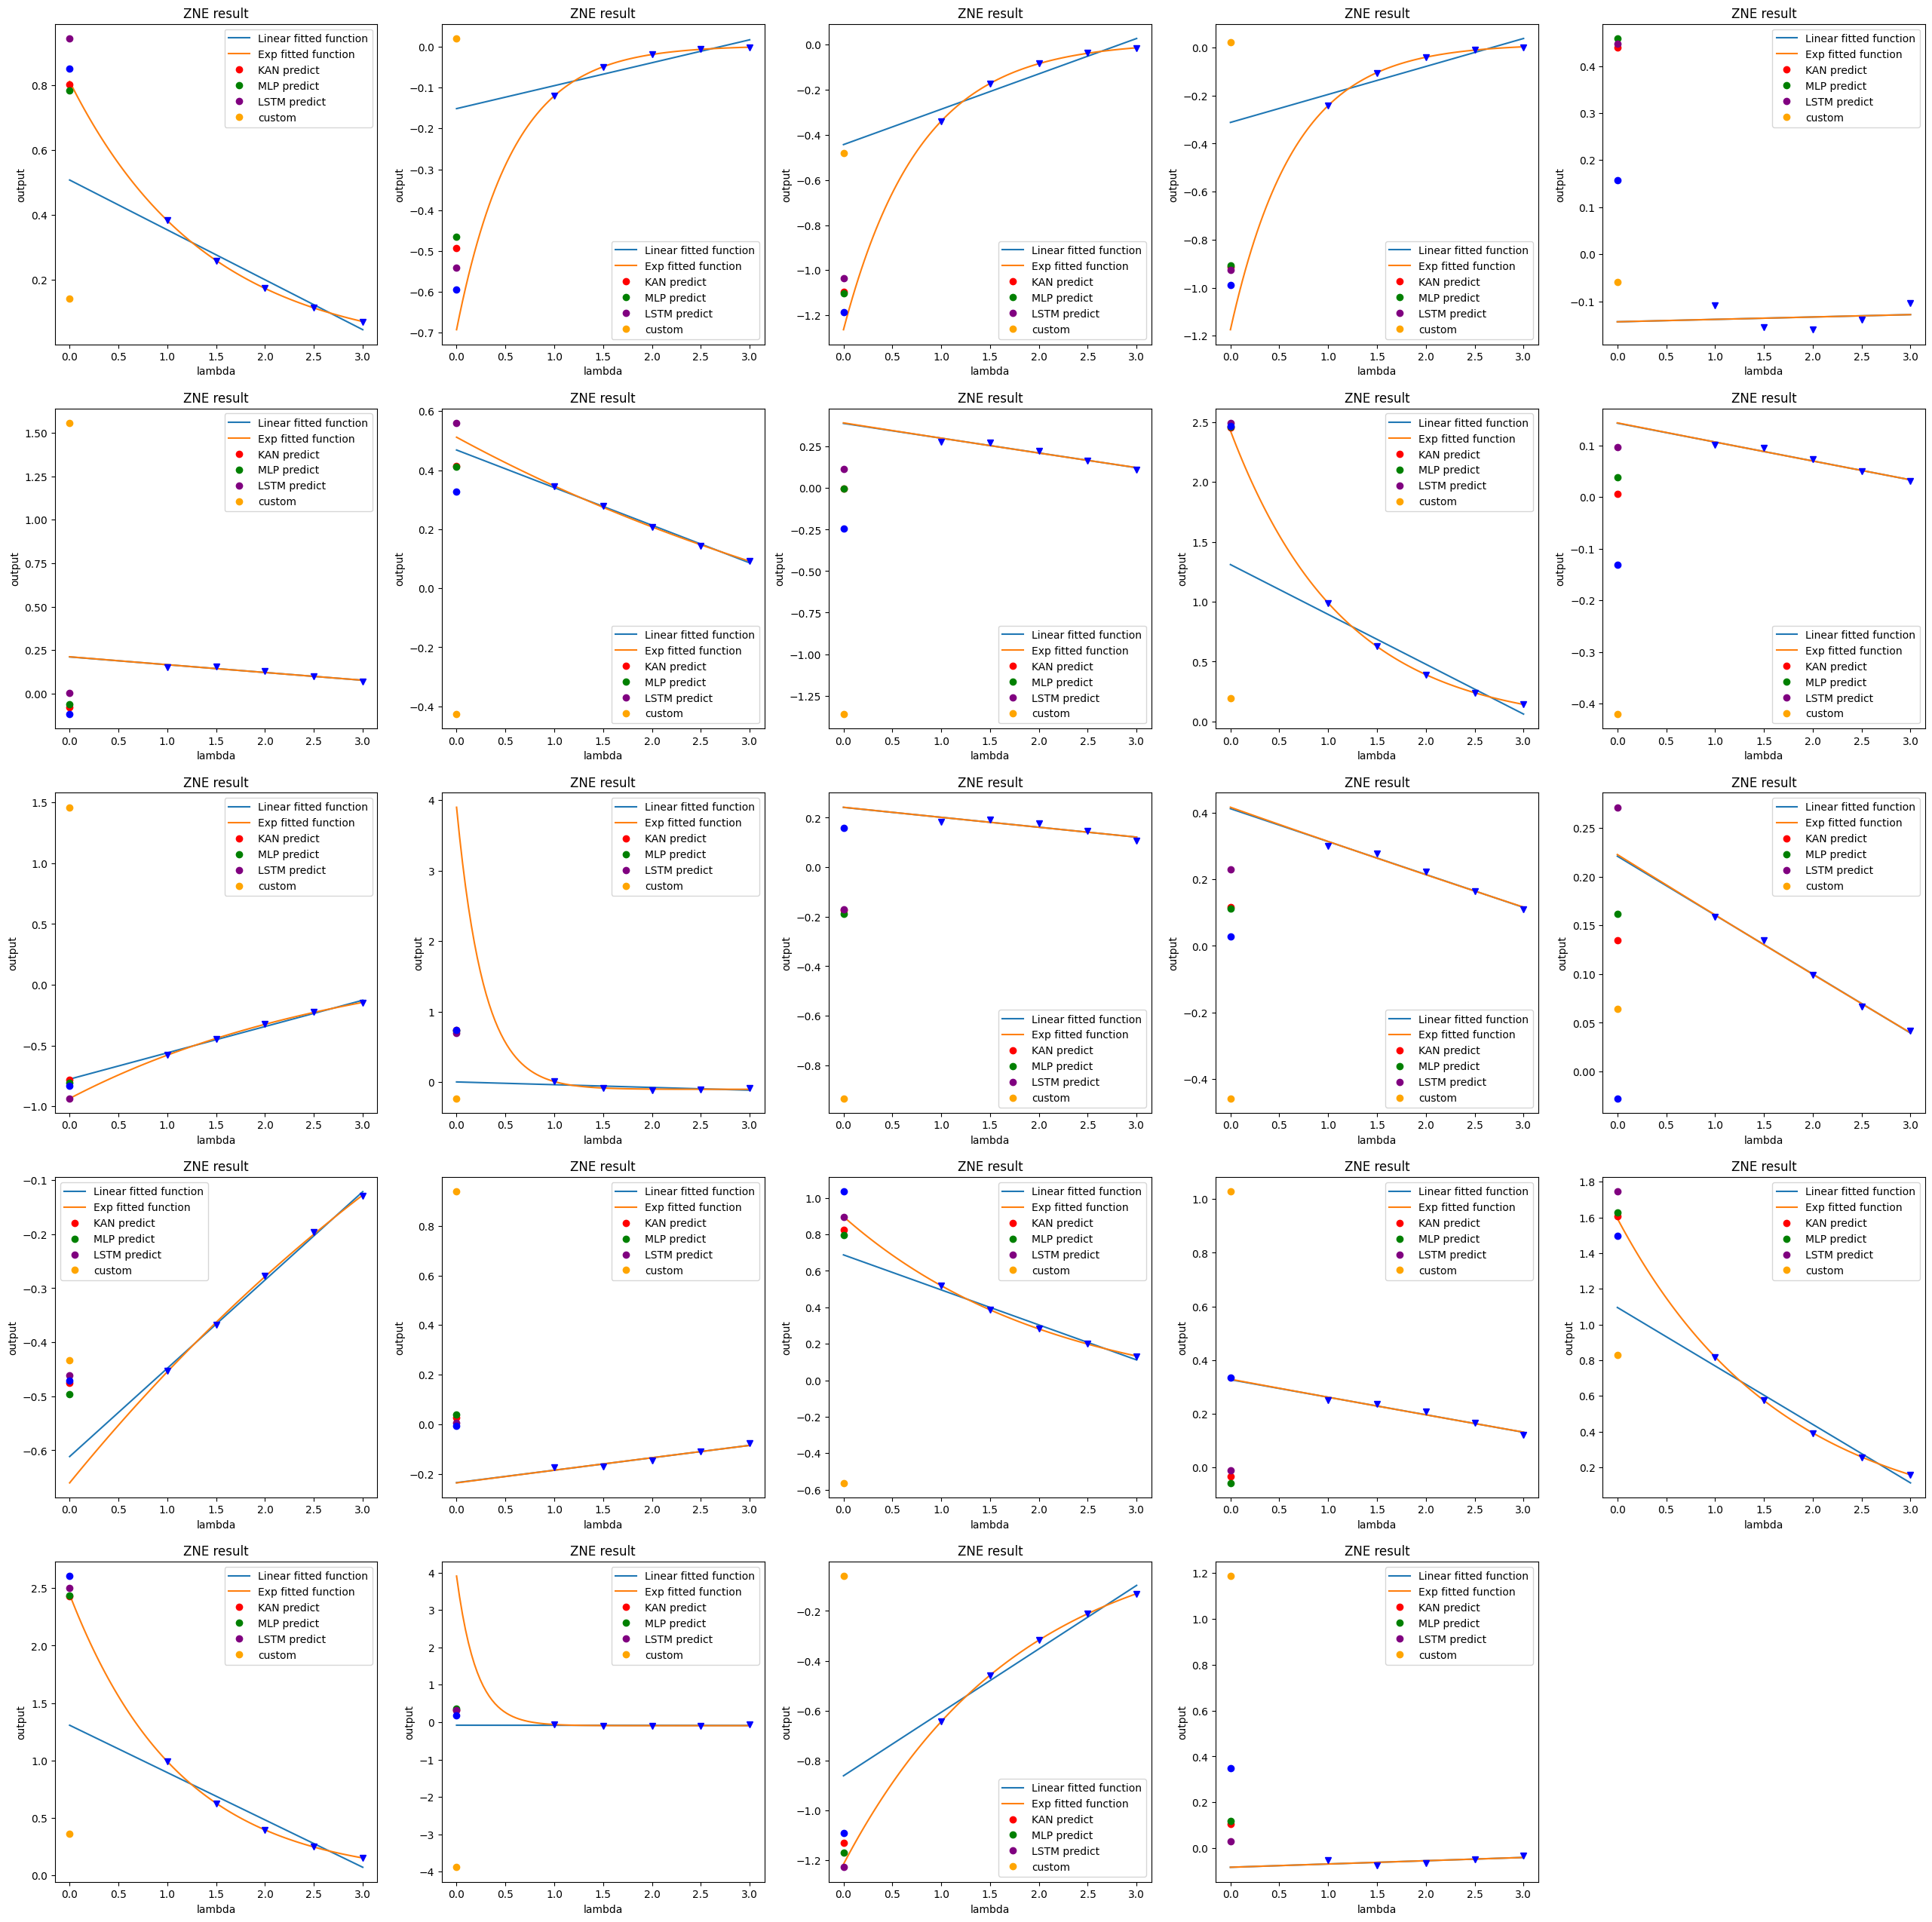

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(32,32))
index = 1
x_tensor = None
y_tensor = None
for (x,y) in train_dataset:
    
    y = torch.unsqueeze(y,dim=0)
    if x_tensor is None:
        x_len = len(x)
        x_tensor = x
        y_tensor = y
    else:
        x_tensor = torch.concat([x_tensor,x],dim=0)
        y_tensor = torch.concat([y_tensor,y],dim=0)
x_tensor = torch.reshape(x_tensor,[-1,len(x)])
y_tensor = torch.reshape(y_tensor,[-1,1])

output_KAN = model(x_tensor).detach().numpy()
output_MLP = model_MLP(x_tensor).detach().numpy()
output_LSTM = LSTM_model(x_tensor).detach().numpy()

model_outputs = [output_KAN,output_MLP,output_LSTM]
colors = ['red','green','purple','orange']
models = ['KAN','MLP','LSTM']

for (x,y) in train_dataset:
    if index <25:
        
        
        
        
        plt.subplot(5,5,index)
        plt.title("ZNE result")
        plt.xlabel("lambda")
        plt.ylabel("output")
        curve_plot(input_list2,x)
        
        for index2,output in enumerate(model_outputs):
            plt.plot([0],output[index-1],'o',color=colors[index2],label=f'{models[index2]} predict')
        
        plt.plot([0],y_temp_list[index-1],'o',color=colors[-1],label = 'custom')
        plt.plot(input_list2,list(x),'bv')
        plt.plot([0],y,'bo')
    
        plt.legend()
        index+=1
    else:
        break

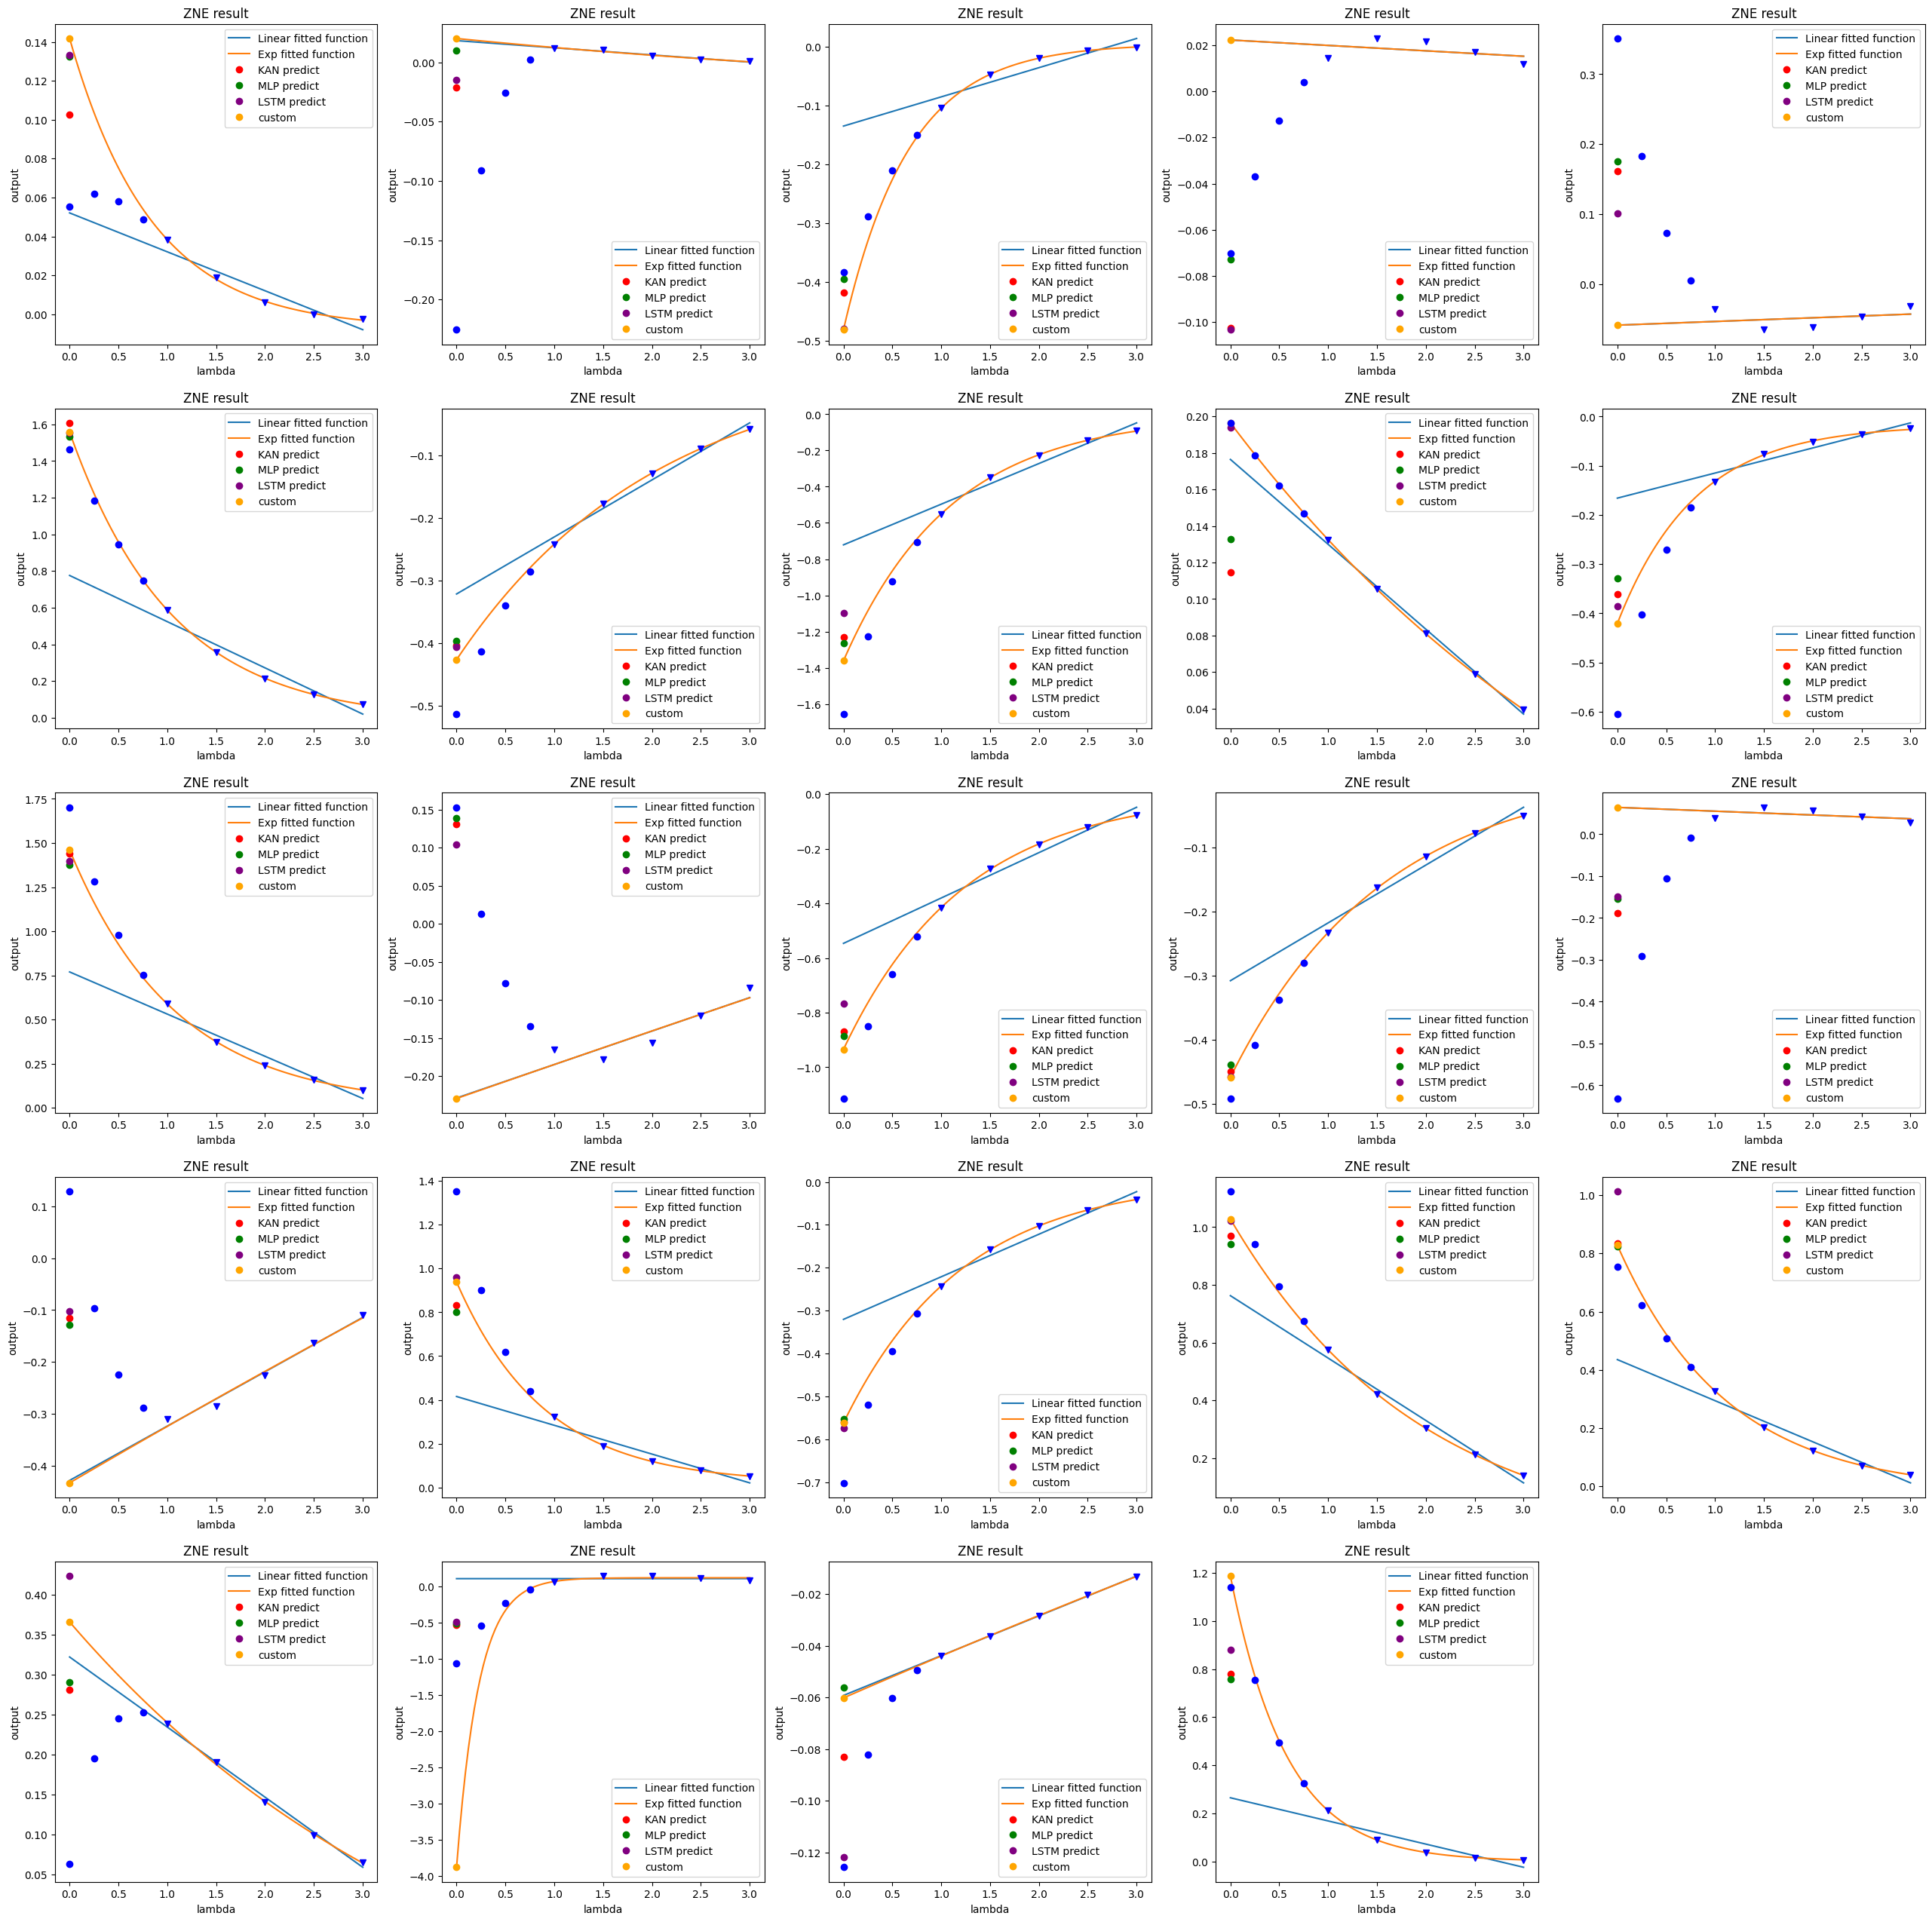

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(32,32))
index = 1
x_tensor = None
y_tensor = None
for (x,y),(x1,y1) in zip(val_dataset,val_dataset_temp):
    
    y = torch.unsqueeze(y,dim=0)
    if x_tensor is None:
        x_len = len(x)
        x_tensor = x
        y_tensor = y
    else:
        x_tensor = torch.concat([x_tensor,x],dim=0)
        y_tensor = torch.concat([y_tensor,y],dim=0)
x_tensor = torch.reshape(x_tensor,[-1,len(x)])
y_tensor = torch.reshape(y_tensor,[-1,1])

output_KAN = model(x_tensor).detach().numpy()
output_MLP = model_MLP(x_tensor).detach().numpy()
output_LSTM = LSTM_model(x_tensor).detach().numpy()

model_outputs = [output_KAN,output_MLP,output_LSTM]
colors = ['red','green','purple','orange']
models = ['KAN','MLP','LSTM']

for (x,y),(x1,y1) in zip(val_dataset,val_dataset_temp):
    if index <25:
        
        
        
        
        plt.subplot(5,5,index)
        plt.title("ZNE result")
        plt.xlabel("lambda")
        plt.ylabel("output")
        curve_plot(input_list2,x)
        
        for index2,output in enumerate(model_outputs):
            plt.plot([0],output[index-1],'o',color=colors[index2],label=f'{models[index2]} predict')
        
        plt.plot([0],y_temp_list[index-1],'o',color=colors[-1],label = 'custom')
        plt.plot(input_list1[:4],list(x1[:4]),'bo')
        plt.plot(input_list2,list(x),'bv')

    
        plt.legend()
        index+=1
    else:
        break

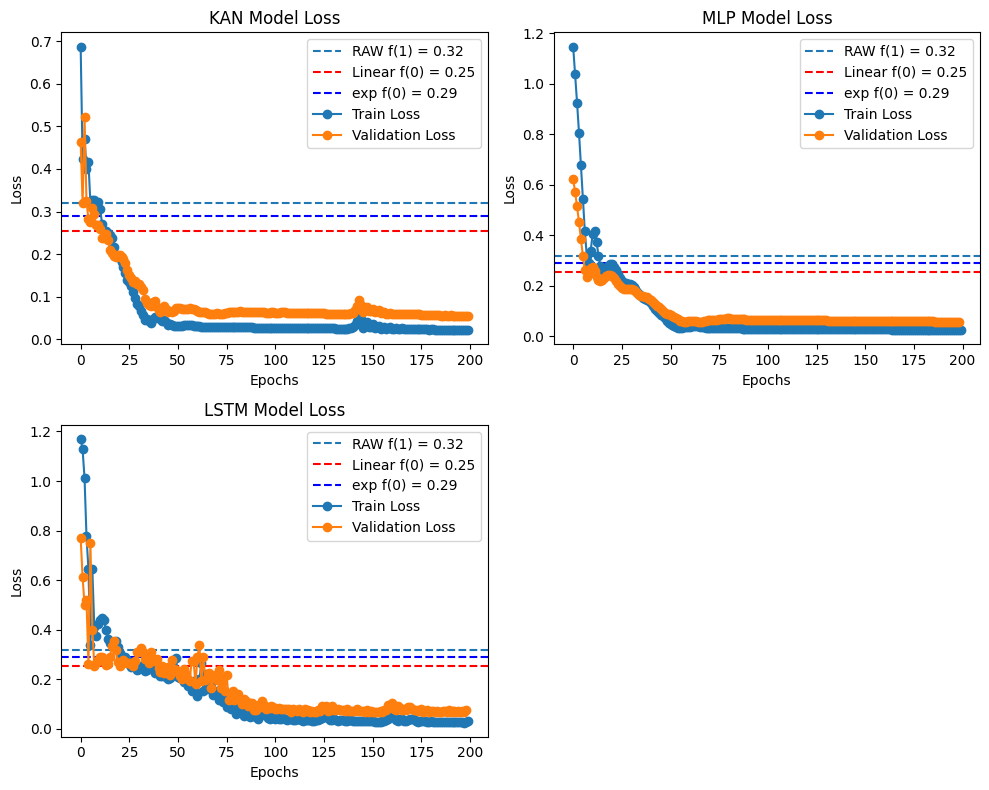

In [ ]:
import matplotlib.pyplot as plt



# 예시 데이터
KAN_model_train_loss = train_seq_KAN.train_loss_list
KAN_model_val_loss = train_seq_KAN.loss_list
MLP_model_train_loss = train_seq.train_loss_list
MLP_model_val_loss = train_seq.loss_list
LSTM_model_train_loss = train_seq_LSTM.train_loss_list
LSTM_model_val_loss = train_seq_LSTM.loss_list







# KAN 모델 Loss 플롯
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")

plt.plot(KAN_model_train_loss, label='Train Loss', marker='o')
plt.plot(KAN_model_val_loss, label='Validation Loss', marker='o')
plt.title('KAN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MLP 모델 Loss 플롯
plt.subplot(2, 2, 2)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")
plt.plot(MLP_model_train_loss, label='Train Loss', marker='o')
plt.plot(MLP_model_val_loss, label='Validation Loss', marker='o')
plt.title('MLP Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MLP 모델 Loss 플롯
plt.subplot(2, 2, 3)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")
plt.plot(LSTM_model_train_loss, label='Train Loss', marker='o')
plt.plot(LSTM_model_val_loss, label='Validation Loss', marker='o')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


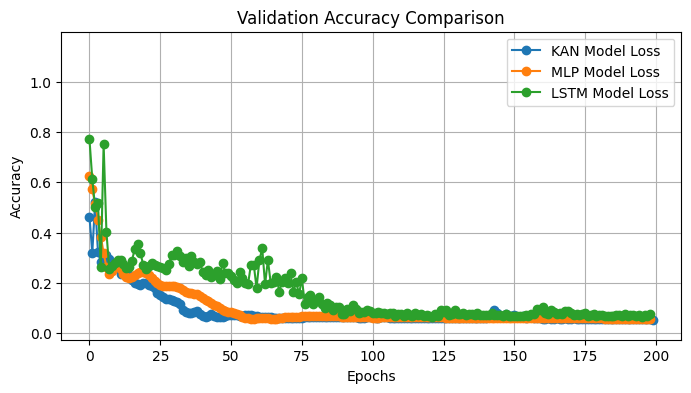

In [ ]:
import matplotlib.pyplot as plt

# Epochs
# 정확도 플롯
plt.figure(figsize=(8, 4))
plt.plot(KAN_model_val_loss, label='KAN Model Loss', marker='o')
plt.plot(MLP_model_val_loss, label='MLP Model Loss', marker='o')
plt.plot(LSTM_model_val_loss, label='LSTM Model Loss', marker='o')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(np.min(MLP_model_train_loss)-0.05,np.max(MLP_model_train_loss)+0.05)
plt.show()